In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from dataset import Dataset
from features import StrategiesSignals
import plotly.graph_objects as go

# Download data from binance

In [2]:
TICKER = "BTCUSDT"
data_binance = Dataset()
data = data_binance.get_data(days=90, ticker=TICKER, ts='5m')

In [3]:
data.tail(5)

,open,high,low,close,volume
time,,,,,
2021-09-11 23:45:00,45093.52,45106.94,44976.00,45025.44,102.60879
2021-09-11 23:50:00,45025.75,45106.18,45003.53,45062.07,62.87858
2021-09-11 23:55:00,45062.08,45103.37,45003.53,45099.99,57.81696
2021-09-12 00:00:00,45099.99,45175.82,45062.51,45173.69,77.45159
2021-09-12 00:05:00,45173.68,45200.00,45096.04,45113.99,129.85556


# Create target variables

In [4]:
size_body = 0.8
def find_candle(candle, size_body):
    rule_1 = (candle.get('close') - candle.get('low')) / (.001 + candle.get('high') - candle.get('low'))
    rule_2 = (candle.get('open') - candle.get('low')) / (.001 + candle.get('high') - candle.get('low'))
    rule_3 = candle.get('close') > candle.get('open')
    
    # Define rules
    bar = (
        ((candle.get('high') - candle.get('low')) > 3*(candle.get('open') - candle.get('close'))) &
        ((rule_1 > size_body) & (rule_1 < 1)) &
        ((rule_2 > size_body) & (rule_2 < 1)) &
        (rule_3))
    return 1 if bar else 0


In [5]:
# Look for the biggest volume for the last 1 hour (12 bars)
data['rolling_volume'] = data['volume'].rolling(5).max()
data[['volume', 'rolling_volume']].tail(10)

,volume,rolling_volume
time,,
2021-09-11 23:20:00,214.74049,214.74049
2021-09-11 23:25:00,108.13291,214.74049
2021-09-11 23:30:00,82.88363,214.74049
2021-09-11 23:35:00,56.19440,214.74049
2021-09-11 23:40:00,117.15919,214.74049
2021-09-11 23:45:00,102.60879,117.15919
2021-09-11 23:50:00,62.87858,117.15919
2021-09-11 23:55:00,57.81696,117.15919
2021-09-12 00:00:00,77.45159,117.15919


In [6]:
# Look for correction
data['rolling_price_min'] = data['close'].rolling(12).min()
data[['close', 'rolling_price_min']].tail(10)

,close,rolling_price_min
time,,
2021-09-11 23:20:00,45119.92,45035.14
2021-09-11 23:25:00,45193.80,45035.14
2021-09-11 23:30:00,45217.23,45035.14
2021-09-11 23:35:00,45093.75,45035.14
2021-09-11 23:40:00,45093.52,45035.14
2021-09-11 23:45:00,45025.44,45025.44
2021-09-11 23:50:00,45062.07,45025.44
2021-09-11 23:55:00,45099.99,45025.44
2021-09-12 00:00:00,45173.69,45025.44


In [7]:
data['signal'] = 0
for index, value in data.iterrows():
    # find pattern
    data.loc[index, 'signal'] = find_candle(value, size_body)
    # find the biggest volume
    data.loc[index, 'signal_volume'] = 1 if value.get(
        'volume') == value.get('rolling_volume') else 0
    # find correction
    data.loc[index, 'signal_correction'] = (
        1 if value.get('close') / value.get('rolling_price_min') > 0.995 else 0
    )


# Plot patterns

In [8]:
# We need check what is patterns
indexex = data[data['signal'] == 1].index
# Select indexes
temp = data[data.index == indexex[30]]
fig = go.Figure(data=[go.Candlestick(x=temp.index,
                                     open=temp['open'],
                                     high=temp['high'],
                                     low=temp['low'],
                                     close=temp['close'])])
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()


In [9]:
temp = data[
    (data['signal'] == 1) &
    (data['signal_volume'] == 1) &
    (data['signal_correction'] == 1)
]
fig = go.Figure()
fig.add_trace(go.Scatter(x=temp.index, y=temp['close'], mode="markers", name='signals'))

fig.add_trace(go.Candlestick(x=data.index,
                             open=data['open'],
                             high=data['high'],
                             low=data['low'],
                             close=data['close'])
              )


fig.show()


In [10]:
# data.groupby('signal').count()
data.groupby(['signal', 'signal_correction', 'signal_volume']).count().T

signal              0                     1    
signal_correction 0.0        1.0        1.0    
signal_volume     0.0 1.0    0.0   1.0  0.0 1.0
open               10   1  20416  5193  194  53
high               10   1  20416  5193  194  53
low                10   1  20416  5193  194  53
close              10   1  20416  5193  194  53
volume             10   1  20416  5193  194  53
rolling_volume      6   1  20416  5193  194  53
rolling_price_min   0   0  20416  5193  194  53

In [11]:

# create lags
lags = range(1, 20)

# run loop to calculate target percent change
for i in lags:
    data[f'lag_{i}'] = data['close'].pct_change(-i)

# generate names of colimns
name_lags = [f'lag_{i}' for i in lags]
# Append our signals
name_lags.append('signal')
name_lags.append('signal_volume')
name_lags.append('signal_correction')
stat_table = data[name_lags].groupby(['signal', 'signal_correction', 'signal_volume']).agg(['median', 'count', 'min', 'max']).T #.plot()
stat_table.head(50)

signal                     0                                                1  \
signal_correction        0.0                     1.0                      1.0   
signal_volume            0.0       1.0           0.0          1.0         0.0   
lag_1  median      -0.000945 -0.004127      0.000004    -0.000006    0.000101   
       count       10.000000  1.000000  20416.000000  5192.000000  194.000000   
       min         -0.002359 -0.004127     -0.018714    -0.060426   -0.009549   
       max          0.003941 -0.004127      0.035350     0.109761    0.007558   
lag_2  median      -0.000040 -0.006476     -0.000014     0.000021   -0.000009   
       count       10.000000  1.000000  20415.000000  5192.000000  194.000000   
       min         -0.003670 -0.006476     -0.026592    -0.086639   -0.013956   
       max          0.003904 -0.006476      0.099454     0.042703    0.010395   
lag_3  median      -0.000985 -0.004006     -0.000049     0.000027   -0.000149   
       count       10.000000  1.000000  20414.000000  5192.000000  194.000000   
       min         -0.005119 -0.004006     -0.036671    -0.082333   -0.019569   
       max          0.003129 -0.004006      0.138320     0.036084    0.018076   
lag_4  median      -0.000149 -0.004996     -0.000081    -0.000017   -0.000387   
       count       10.000000  1.000000  20413.000000  5192.000000  194.000000   
       min         -0.006009 -0.004996     -0.077835    -0.073941   -0.017454   
       max          0.003340 -0.004996      0.069536     0.129653    0.015666   
lag_5  median      -0.001155 -0.003367     -0.000080     0.000013   -0.000017   
       count       10.000000  1.000000  20412.000000  5192.000000  194.000000   
       min         -0.004902 -0.003367     -0.078842    -0.078625   -0.019374   
       max          0.004710 -0.003367      0.155710     0.061393    0.016496   
lag_6  median      -0.001220 -0.003157     -0.000148    -0.000024   -0.000031   
       count       10.000000  1.000000  20411.000000  5192.000000  194.000000   
       min         -0.006691 -0.003157     -0.077652    -0.083818   -0.018269   
       max          0.004221 -0.003157      0.162162     0.062631    0.018039   
lag_7  median      -0.001878 -0.001796     -0.000169    -0.000039   -0.000082   
       count       10.000000  1.000000  20410.000000  5192.000000  194.000000   
       min         -0.008555 -0.001796     -0.079890    -0.089497   -0.021276   
       max          0.002426 -0.001796      0.162942     0.064737    0.021724   
lag_8  median      -0.002598 -0.002282     -0.000198    -0.000060    0.000223   
       count       10.000000  1.000000  20409.000000  5192.000000  194.000000   
       min         -0.015136 -0.002282     -0.081047    -0.079839   -0.021793   
       max          0.002138 -0.002282      0.092671     0.159870    0.026721   
lag_9  median      -0.004580 -0.004065     -0.000206    -0.000109    0.000189   
       count       10.000000  1.000000  20408.000000  5192.000000  194.000000   
       min         -0.017023 -0.004065     -0.082462    -0.075091   -0.028052   
       max          0.001650 -0.004065      0.070255     0.165910    0.024918   
lag_10 median      -0.004413 -0.009322     -0.000211    -0.000196    0.000467   
       count       10.000000  1.000000  20408.000000  5191.000000  194.000000   
       min         -0.015017 -0.009322     -0.069176    -0.078088   -0.024948   
       max          0.000754 -0.009322      0.076230     0.169414    0.023195   
lag_11 median      -0.003567 -0.019081     -0.000240    -0.000156    0.000244   
       count       10.000000  1.000000  20407.000000  5191.000000  194.000000   
       min         -0.016904 -0.019081     -0.088874    -0.069420   -0.022637   
       max         -0.000702 -0.019081      0.171847     0.098752    0.020257   
lag_12 median      -0.003302 -0.020961     -0.000248    -0.000167   -0.000066   
       count       10.000000  1.000000  20406.000000  5191.000000  194.000000   
       min         -0.015216 -0

In [14]:
# Look for the best returns
stat_table = stat_table.rename_axis(["lvl0", "lvl1"])
stat_table.groupby(level=1).max()
stat_table.loc[stat_table.query("lvl1 == 'median'").idxmax(), :]

signal                    0                                       1          
signal_correction       0.0                 1.0                 1.0          
signal_volume           0.0       1.0       0.0       1.0       0.0       1.0
lvl0   lvl1                                                                  
lag_2  median     -0.000040 -0.006476 -0.000014  0.000021 -0.000009  0.000250
lag_7  median     -0.001878 -0.001796 -0.000169 -0.000039 -0.000082  0.000729
lag_1  median     -0.000945 -0.004127  0.000004 -0.000006  0.000101 -0.000113
lag_3  median     -0.000985 -0.004006 -0.000049  0.000027 -0.000149  0.000607
lag_10 median     -0.004413 -0.009322 -0.000211 -0.000196  0.000467  0.001198
lag_18 median     -0.004376 -0.005344 -0.000295 -0.000221  0.000453  0.001747

<AxesSubplot:>

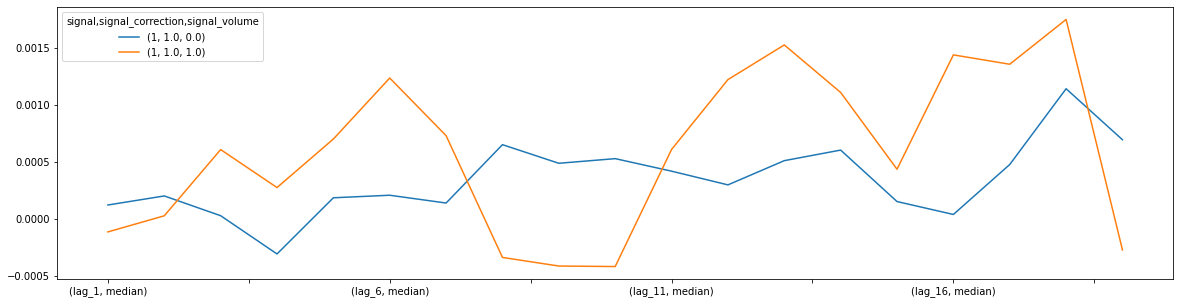

In [23]:
hold_period = data[name_lags].groupby(['signal', 'signal_correction', 'signal_volume']).agg([
    'median']).T.iloc[:, -2:]
# hold_period
hold_period.plot(figsize=(20,5))

# Machine Larning

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import pandas as pd
import numpy as np

## Create target variables using information about statistics in stat_table

In [37]:
data['y'] = data['close'].shift(-18).pct_change()
data['y'] = np.where(data['y'] > 0, 1, 0)

## Test 1
Create model using signals from all dataset

In [65]:
data_ml = data.dropna()
x_train, x_test, y_train, y_test = train_test_split(
    data_ml[['signal', 'signal_correction', 'signal_volume']].values, data_ml['y'].values, test_size=0.25, random_state=0)

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
predict = logisticRegr.predict(x_test)
metrics.confusion_matrix(y_test, predict)
np.sum(predict == y_test) / len(y_test)


array([[2534,  682],
       [2530,  714]])

## Test 2
Build a Model Using Observational Data Only

In [67]:
# df = data[(data['signal'] == 1) & (data['signal_correction'] == 1) & (data['signal_volume'] == 1)]
data_ml = data.dropna().copy()
data_ml.loc[:, 'x'] = np.where((data_ml['signal'] == 1 ) & (data_ml['signal_correction'] == 1) & (data_ml['signal_volume'] == 1), 1, 0)
x_train, x_test, y_train, y_test = train_test_split(
    data_ml['x'].values, data_ml['y'].values, test_size=0.1, random_state=0)

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train.reshape(-1, 1), y_train)
predict = logisticRegr.predict(x_test.reshape(-1, 1))
metrics.confusion_matrix(y_test, predict)
np.sum(predict == y_test) / len(y_test)


0.49419504643962847

In [72]:
data_ml[data_ml['x'] == 1]['y'].value_counts(normalize=True)

0    0.528302
1    0.471698
Name: y, dtype: float64